<a href="https://colab.research.google.com/github/OthmaneAbder2303/Practical-Deep-Learning/blob/main/CNN/transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
!file cat_vs_dog_dataset.zip

cat_vs_dog_dataset.zip: Zip archive data, at least v4.5 to extract, compression method=deflate


In [20]:
#!unzip -q cat_vs_dog_dataset.zip -d data/

In [21]:
import os
import tensorflow as tf
from PIL import Image, UnidentifiedImageError

data_dir = "data/PetImages"
removed_count = 0
repaired_count = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join(data_dir, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            # Verify image integrity
            with Image.open(fpath) as img:
                img.verify()
            # Re-open and re-save to normalize file format and strip extraneous bytes
            try:
                with Image.open(fpath) as img:
                    rgb = img.convert("RGB")
                    rgb.save(fpath, format="JPEG", quality=95)
                repaired_count += 1
            except Exception:
                # If re-saving fails, remove file
                os.remove(fpath)
                removed_count += 1
        except (UnidentifiedImageError, OSError, IOError, tf.errors.InvalidArgumentError):
            # File is not a valid image or corrupted - remove it
            try:
                os.remove(fpath)
            except Exception:
                pass
            removed_count += 1

print(f"{removed_count} images removed, {repaired_count} images re-saved (repaired).")

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


4 images removed, 24998 images re-saved (repaired).


In [22]:
from tensorflow import keras

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

Found 24998 files belonging to 2 classes.
Using 19999 files for training.
Found 24998 files belonging to 2 classes.
Using 4999 files for validation.


In [23]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)

In [24]:
import tensorflow
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Flatten
from keras.applications.vgg16 import VGG16

base_model = VGG16(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(1, activation='sigmoid')
])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 8, 8, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,103,809 (88.13 MB)

 Trainable params: 8,389,121 (32.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [25]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [26]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 346ms/step - accuracy: 0.8573 - loss: 0.5463 - val_accuracy: 0.9130 - val_loss: 0.2042
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 308ms/step - accuracy: 0.9494 - loss: 0.1276 - val_accuracy: 0.9358 - val_loss: 0.1638
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 308ms/step - accuracy: 0.9612 - loss: 0.0963 - val_accuracy: 0.9284 - val_loss: 0.1878
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 309ms/step - accuracy: 0.9722 - loss: 0.0695 - val_accuracy: 0.9330 - val_loss: 0.1997
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 193s 309ms/step - accuracy: 0.9762 - loss: 0.0579 - val_accuracy: 0.9386 - val_loss: 0.2062


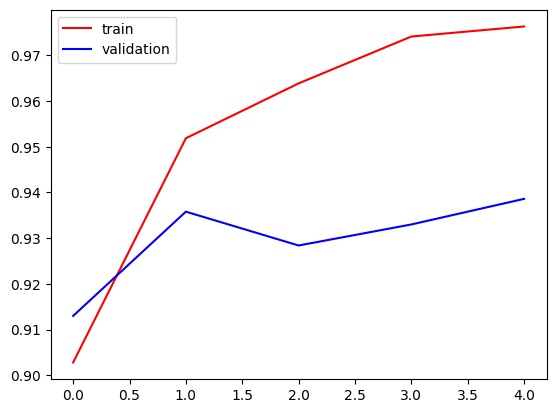

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

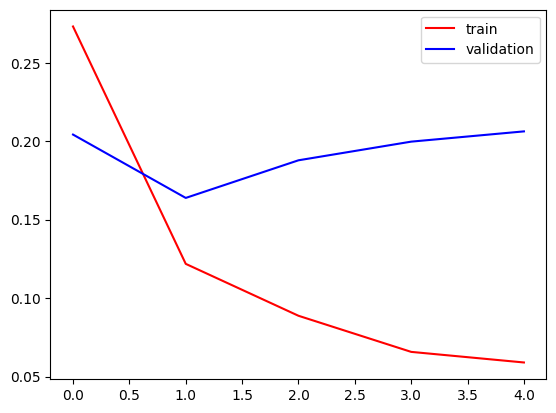

In [28]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()